In [85]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'eqtl_processing'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

import gc

In [86]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')
qvalue = importr('qvalue')

In [87]:
dy_name = 'qtl_results_01_17'
outdir = os.path.join(private_out, dy_name)

if not os.path.exists(outdir):
    DJ.makedir(outdir)

In [88]:
def prep_info_all(df): 
    df = df.copy()
    df['chrom'] = df.CHROM.apply(lambda x: "chr{}".format(str(x)))
    df = df.set_index('ID', drop = False)
    return df

In [89]:
def add_bins(df, bins, col = 'log10_SVLEN', name_suff = 'bin_log10_SVLEN', 
            cap_thresh = 4):

    bins = [round(x, 1) for x in bins]
    df[name_suff] = pd.cut(df[col], bins , labels= bins[1:])
    df[name_suff] = df[name_suff].astype(float)
    df["{}_capped".format(name_suff)] = df[name_suff]
    inds = df[df[name_suff] > cap_thresh].index.tolist()
    df.loc[inds, "{}_capped".format(name_suff)] = cap_thresh
    return df

In [90]:
# via cdeboever https://github.com/frazer-lab/cardips-ipsc-eqtl/blob/master/notebooks/eQTL%20Processing.ipynb
def qvalue(pvals_series, summary=True, plot=False):
    """Use the R qvalue package to adjust pvalues. pvals should be a pandas
    Series with gene names as the index and pvalues as the values."""
    import rpy2.robjects as ro
    pvals = pvals_series.tolist()
    
    ro.r('suppressMessages(library(qvalue))')
    
    ro.globalenv['pvals'] = FloatVector(pvals)
    ro.r('qobj = qvalue(p=pvals, fdr.level=0.05)')
    ro.r('qvalues <- qobj$qvalues')
    ro.r('pi0 <- qobj$pi0')
    ro.r('lfdr <- qobj$lfdr')
    ro.r('sig <- qobj$significant')
    qvalues = ro.globalenv['qvalues']
    pi0 = ro.globalenv['pi0']
    lfdr = ro.globalenv['lfdr']
    sig = ro.globalenv['sig']
    qvalue_res = pd.DataFrame([list(pvals), list(qvalues), list(sig)], 
                              index=['perm_pvalue', 'perm_qvalue', 'perm_sig'],
                              columns=pvals_series.index).T
    qvalue_res['perm_sig'] = qvalue_res.perm_sig.astype(bool)
    qvalue_res = qvalue_res.sort_values(['perm_qvalue'])
    qvalues = pd.Series(list(qvalues), index=pvals_series.index)
    qvalue_res.index.name = None
    if summary:
        ro.r('summary(qobj)')
    if plot:
        ro.r('plot(qobj)')
    return qvalue_res

In [91]:
def dist_lambda(df, col_start1, col_end1, col_start2, col_end2):

    data = []
    for x in df[[col_start1, col_end1, col_start2, col_end2]].values:
        l = map(int, x)
        
        start1, end1 = l[0], l[1]     
        start2, end2 = l[2], l[3]
    

        ## CNV before
        if start1 < start2 and end1 <= start2:
            dist = end1 - start2
        ## CNV after 
        elif start1 > end2:
            dist = start1- end2

        ## CNV overlaps right edge:
        elif start1 < start2 and end1 > start2 and end1 < end2:
            dist = 0
        ## CNV overlaps left edge

        elif start1 >= start2 and start1 <= end2 and end1 >= end2:
            dist=0

        ## CNV Overlaps entire region:
        elif start1 <= start2 and end1 >= end2:

            dist =0

        ## CNV_within entirely
        elif start1 >= start2 and start1 <= end2 and end1 >= start2 and end1 <= end2:
            dist = 0

        else:
            print start1, start2, end1, end2
            return
        
        data.append(dist)
    return data

In [92]:
def add_fdr(df, n=False, method = 'fdr'):
    df = df.copy()
    p_vals = df['empirical_feature_p_value'].tolist()
    if n:
        p_adjust = stats.p_adjust(FloatVector(p_vals), method = method, n = n)
    else:
        p_adjust = stats.p_adjust(FloatVector(p_vals), method = method)
        
    df['fdr_global'] = list(p_adjust)
    return df


def get_pval_threshold_for_fdr(top, fdr = 0.1):
    """ get the min permutation p value that for rejection at the specified fdr
    p values lower than this one are pass fdr filtering"""
    thresh = top[top.fdr_global > fdr]['empirical_feature_p_value'].min()
    return thresh

In [93]:
def add_info_cats_per_gene(top_sig):
    # merge the info onto the top hits df
    top_sig = pd.merge(top_sig, info_cat_per_gene_all[['gene_id_mod', 'ID', 'genic_category_variant']], how='left', left_on=['feature_id', 'snp_id'], right_on=['gene_id_mod', 'ID'])

    top_sig['genic_category_variant'] = top_sig.genic_category_variant.fillna('intergenic')
    
    top_sig['coding'] = False
    inds = top_sig[top_sig.genic_category_variant.isin(['contains_gene', 'contains_exon', 'intersects_exon'])].index.tolist()
    top_sig.loc[inds, 'coding'] = True    
    return top_sig

In [94]:
def correct_betas(qtl_info, info_vars):
    
    inds1 = info_vars[(info_vars.SUBTYPE == 'DEL') & (info_vars.CALLER.isin(['HipSTR', 'GS', 'GS_LCNV']))].index.tolist()
    inds2 = info_vars[(info_vars.SVTYPE_NR == 'DEL') & (info_vars.CALLER.isin(['GS', 'GS_LCNV']))].index.tolist()
    inds = list(set(inds1 + inds2))
    
    qtl_info['beta_correct_factor'] = 1
    inds_correct = qtl_info[qtl_info.snp_id.isin(inds)].index.tolist()
    qtl_info.loc[inds_correct, 'beta_correct_factor'] = -1
    qtl_info['beta_corrected'] = qtl_info['beta'] * qtl_info['beta_correct_factor'] 
#     mask = var_egene_nr[(var_egene_nr.SVTYPE_NR == 'DEL') & (var_egene_nr.CALLER == 'GS')].values
#     var_egene_nr.loc[mask, 'beta_corrected'] = var_egene_nr.loc[mask, 'beta']  * -1
#     var_egene_nr['exonic'] =  var_egene_nr.coding # make naming better
    
    return qtl_info

In [95]:
def join_as_dict_apply(df1, df2, cols_to_join, left_on, right_on, fillna = "missing_key", 
                       alternative_col_names = False):
    
    if not alternative_col_names:
        alternative_col_names = copy.deepcopy(cols_to_join)
        
    for i, c in enumerate(cols_to_join):
        alt_cn = alternative_col_names[i]
        d = dict(zip(df2[right_on].tolist(), df2[c].tolist()))
        df1[alt_cn] = df1[left_on].apply(lambda x: d.get(x, fillna))
    return df1

In [96]:
def tag_most_sig_per_cluster_per_gene(all_qtls):
#     all_qtls['NR_ID_tested'] = (all_qtls.snp_id == all_qtls.Non_Redundant_ID)
    
    all_qtls = all_qtls.sort_values(['feature_id', 'Non_Redundant_ID', 'empirical_feature_p_value'])
    all_qtls = all_qtls.set_index('gene_var_id', drop = False)
    t = all_qtls.drop_duplicates(['Non_Redundant_ID', 'feature_id'], keep = 'first')
    inds = t.index.tolist()
    all_qtls['most_significant_nr'] = False
    all_qtls.loc[inds, 'most_significant_nr'] = True
    return all_qtls

In [254]:
# def fix_svlen(info_all):
    
#     info_all = info_all.copy()
# #     info_all['SVLEN_MOD'] = info_all.SVLEN
#     inds = info_all[info_all.SVTYPE_NR == 'STR'].index.tolist()
#     info_all.loc[inds, 'SVLEN'] = info_all.loc[inds, 'MAX_ALLELE_CHANGE']
#     info_all['log10_SVLEN'] = info_all['SVLEN'] 
#     inds = info_all[(info_all.is_SVLEN == True) | (info_all.SVTYPE == 'INV')].index.tolist()
#     info_all.loc[inds, 'log10_SVLEN'] = np.log10(info_all.loc[inds, 'SVLEN'].astype(float))
#     bins = np.arange(0, 10, 0.2)
#     info_all = add_bins(info_all, bins, col = 'log10_SVLEN',
#               name_suff = 'bin_log10_SVLEN', 
#               cap_thresh = 6.2)
    
#     return info_all

In [97]:
def prep_info_pass_for_merge(info):
    info = info.copy()
    c1 =['NR_ID', 'ID', 'CALLER', 'NMODE_all_rna', 'NMODE_AF_all_rna', 'SVTYPE_all_rna', 'SVTYPE_NR', 'ALLELES_DIST_DICT_all_rna', 'SUBTYPE_all_rna', 'MIN_ALLELE_all_rna', 'MAX_ALLELE_all_rna']

    c2 = [u'SVLEN', u'MAX_ALLELE_CHANGE',
       u'ALLELE_DIFF', u'SVLEN_DS_RANGE', u'MHC', u'VDJ', u'centromere',
       u'seg_dupe', u'pseudo_auto', u'is_SVLEN', u'log10_SVLEN',
       u'log10_SVLEN_DS_RANGE', u'bin_log10_SVLEN', u'bin_log10_SVLEN_capped',
       u'bin_log10_SVLEN_DS_RANGE', u'bin_log10_SVLEN_DS_RANGE_capped',
       u'super_category', u'genes_affected', u'num_genes_affected',
       u'start_variant', u'end_variant', u'ucsc_coords', u'chrom']

    tdf = info[c1 + c2]
    tdf.columns = map(lambda x: x.replace('_all_rna', ''), tdf.columns.tolist())
    return tdf

In [98]:
def get_tss_dist(tss_info, all_qtls_filt):
    cols = ['start_tss', 'end_tss', 'gene_id_mod_tss', 'tss_id_tss']
    tss_ve = all_qtls_filt.merge(tss_info[cols], left_on=['feature_id'], right_on=['gene_id_mod_tss'])

    dfs = []
    cols = ['feature_id', 'start_variant', 'end_variant', 'start_tss', 'end_tss', 'snp_id', 'gene_var_id']
    for i, df in tss_ve[cols].groupby('feature_id'):
        df['dist_tss'] = dist_lambda(df, 'start_variant', 'end_variant','start_tss', 'end_tss')
        df['dist_tss_abs'] = df['dist_tss'].abs()
        cols = ['feature_id', 'snp_id', 'dist_tss', 'dist_tss_abs', 'gene_var_id']
        dfs.append(df[cols])

    tss_dist = pd.concat(dfs, ignore_index = True)
    min_tss_dist = tss_dist.groupby('gene_var_id').dist_tss_abs.min()
    tss_dist['min_tss_dist'] = tss_dist.gene_var_id.map(min_tss_dist.to_dict())
    tss_dist = tss_dist[tss_dist.dist_tss_abs ==tss_dist.min_tss_dist].drop_duplicates('gene_var_id')
    return tss_dist

In [99]:
def annotate_qtl_data(all_qtls, top, info_cat_per_gene_all, info_all_var, info_var_gene_wide,
                      gene_types, mappings = False, genes_filt = False, fdr_thresh = 0.1):
    all_qtls['gene_var_id'] = all_qtls['feature_id'] + '_' + all_qtls['snp_id']
    
    all_qtls = all_qtls.drop_duplicates('gene_var_id')
    print all_qtls.shape[0], 1
    # merge the info onto the top hits df
    all_qtls = pd.merge(all_qtls, info_cat_per_gene_all[['gene_id_mod', 'ID', 'genic_category_variant']], how='left', left_on=['feature_id', 'snp_id'], right_on=['gene_id_mod', 'ID'])
    print all_qtls.shape[0], 2
    info_all_trunc = info_all_var.pipe(prep_info_pass_for_merge)
    all_qtls = all_qtls.merge(info_all_trunc, left_on='snp_id', right_on= 'ID', how = 'left')
    all_qtls['genic_category_variant'] = all_qtls['genic_category_variant'].fillna('intergenic')
    all_qtls['Non_Redundant_ID'] = all_qtls['NR_ID']
    p_val_sig_all = get_pval_threshold_for_fdr(top, fdr=fdr_thresh)
    print all_qtls.shape[0] , 3
    all_qtls['coding'] = False
    inds = all_qtls[all_qtls.genic_category_variant.isin(['contains_gene', 'contains_exon', 'intersects_exon'])].index.tolist()
    all_qtls.loc[inds, 'coding'] = True    
    all_qtls['significant'] = (all_qtls['empirical_feature_p_value'] < p_val_sig_all)
    
    all_qtls = correct_betas(all_qtls, info_all_trunc)
    all_qtls['top_hit'] = all_qtls.gene_var_id.isin(top.gene_var_id.tolist())
    print all_qtls.shape[0], 4
    
    if type(mappings) == pd.core.frame.DataFrame:
        mappings_dict = mappings.Non_Redundant_ID.to_dict()
        svtypes_dict = mappings.SVTYPE.to_dict()
        all_qtls['SVTYPE_NR'] = all_qtls.SVTYPE
        all_qtls['Non_Redundant_ID'] = all_qtls['snp_id'].apply(lambda x: mappings_dict.get(x, x))
        all_qtls['SVTYPE_NR'] = all_qtls['snp_id'].apply(lambda x: svtypes_dict.get(x, x))
        
    if type(genes_filt) != bool:
        all_qtls['in_filtered_genes'] = all_qtls.feature_id.isin(genes_filt.index.tolist())
    
    all_qtls = tag_most_sig_per_cluster_per_gene(all_qtls)
#     return all_qtls
    
    all_qtls['gene_distance'] = all_qtls.pipe(dist_lambda, 'start_variant', 'end_variant', 
                                              'feature_start', 'feature_end')
    print all_qtls.shape[0],5 
    all_qtls = all_qtls.drop(['ID_x', 'ID_y'], axis = 1)
    info_var_gene_wide.index = info_var_gene_wide.ID
    
#     all_qtls = all_qtls.merge(info_var_gene_wide[['super_category', 'genes_supercategory', 'num_genes_affected']], left_on= 'snp_id', right_index=True, how = 'left')f
    
    all_qtls = all_qtls.merge(gene_types[['gene_type', 'gene_name']], left_on= 'feature_id', 
                              right_index=True, how = 'left')
    all_qtls['top_hit_final'] = all_qtls.gene_var_id.isin(top.gene_var_id.tolist())
    print all_qtls.shape[0], 6
    return all_qtls

In [126]:
def prep_top(top, genes_filt):
    top = top.copy()
    top['gene_var_id'] = top['feature_id'] + '_' + top['snp_id']
    top = top[top.feature_id.isin(genes_filt.index.tolist())]
    # added
    top.sort_values(['empirical_feature_p_value'])
    top = top.drop_duplicates('feature_id')

#     top = top[top.feature_id.isin(genes_filt.index.tolist())]
    return top

In [127]:
def general_info_qtls(all_output, col = 'SVTYPE_NR'):
    inds= all_output.snp_id.unique().tolist()
#     input_variants = info_all_vars.loc[inds].SVTYPE_NR.value_counts().to_frame('no. variants tested')
    input_variants = all_output.groupby(col).snp_id.unique().apply(len).to_frame('no. variants tested')
    non_redundant_vars_per_class = all_output.groupby(col).Non_Redundant_ID.apply(lambda x: len(set(x))).to_frame('unique variants non-redundant tested')
    
    genes_tested_per_class = all_output.groupby(col).feature_id.apply(lambda x: len(set(x))).to_frame('unique genes tested')
    
    t1 = all_output[all_output.significant == True][col].value_counts().to_frame('significant_assoc')

    t2 = all_output[all_output.significant == True].groupby(col).feature_id.apply(lambda x: len(set(x))).to_frame('unique eGenes')

    t3 = all_output[all_output.significant == True].groupby(col).snp_id.apply(lambda x: len(set(x))).to_frame('unique eVariants')

    t4 = all_output[all_output.significant == True].groupby(col).Non_Redundant_ID.apply(lambda x: len(set(x))).to_frame('unique eVariants Non Redundant')
    
    general_numbers_fdr10 = pd.concat([t1, t2, t3, t4, input_variants, non_redundant_vars_per_class,
                                   genes_tested_per_class], axis = 1)

    general_numbers_fdr10['fraction of tested genes with significant assoc.'] = general_numbers_fdr10['unique eGenes'] / general_numbers_fdr10['unique genes tested']

    general_numbers_fdr10['fraction variants with significant assoc.'] = general_numbers_fdr10['unique eVariants']/ general_numbers_fdr10['no. variants tested'] 

    general_numbers_fdr10['fraction NR variants with significant assoc.'] = general_numbers_fdr10['unique eVariants Non Redundant']/ general_numbers_fdr10['unique variants non-redundant tested'] 
    general_numbers_fdr10.loc['total'] = general_numbers_fdr10.sum(axis = 0)
    
    return general_numbers_fdr10

In [128]:
def general_info_th_qtls(all_output, col = 'SVTYPE_NR'):
    inds= all_output.snp_id.unique().tolist()
    input_variants = all_output.groupby(col).snp_id.unique().apply(len).to_frame('no. variants tested')
    
#     input_variants = info_all_vars.loc[inds].SVTYPE_NR.value_counts().to_frame('no. variants tested')
    
    non_redundant_vars_per_class = all_output.groupby(col).Non_Redundant_ID.apply(lambda x: len(set(x))).to_frame('unique variants non-redundant tested')
    
    genes_tested_per_class = all_output.groupby(col).feature_id.apply(lambda x: len(set(x))).to_frame('unique genes tested')
    top_sig = all_output[(all_output.significant == True) & (all_output.lead_qtl)]
    t1 = top_sig[col].value_counts().to_frame('Lead_QTLs')

    t2 = top_sig.groupby(col).feature_id.apply(lambda x: len(set(x))).to_frame('unique eGenes')

    t3 = top_sig.groupby(col).snp_id.apply(lambda x: len(set(x))).to_frame('unique eVariants')

    t4 = top_sig.groupby(col).Non_Redundant_ID.apply(lambda x: len(set(x))).to_frame('unique eVariants Non Redundant')
    
    general_numbers_fdr10 = pd.concat([t1, t2, t3, t4, input_variants, non_redundant_vars_per_class,
                                   genes_tested_per_class], axis = 1)

    general_numbers_fdr10['fraction of tested genes with lead QTL'] = general_numbers_fdr10['unique eGenes'] / general_numbers_fdr10['unique genes tested']

    general_numbers_fdr10['fraction variants that are lead QTL'] = general_numbers_fdr10['unique eVariants']/ general_numbers_fdr10['no. variants tested'] 

    general_numbers_fdr10['fraction NR variants that are lead QTL'] = general_numbers_fdr10['unique eVariants Non Redundant']/ general_numbers_fdr10['unique variants non-redundant tested'] 
    
    general_numbers_fdr10.loc['total'] = general_numbers_fdr10.sum(axis = 0)
    general_numbers_fdr10.loc['total', 'unique eGenes'] = top_sig.feature_id.unique().shape[0]
    
    return general_numbers_fdr10

In [129]:
def prep_tx_info(df):
    df = df.copy()
    df['gene_id_mod'] = df.gene_id.apply(lambda x: x.split('.')[0])
    df = df.set_index('tx_id', drop = False)
    return df

def prep_promoter_info(df, tx_info):
    df = df.copy()
#     df['gene_id_mod'] = df.tx_id.apply(lambda x: x.split('.')[0])
    df['tx_id'] = df.tx_id.apply(lambda x: x.split('_')[0])
    
    df = df.set_index('tx_id', drop = False)
    df = df.join(tx_info[['gene_id', 'gene_id_mod']])
    
    return df

def prep_gene_info(df):
    df = df.copy()
    df['gene_id_mod'] = df.gene_id.apply(lambda x: x.split('.')[0])
    df = df.set_index('gene_id_mod', drop = False)
    return df

def prep_tss_info(df, tx_info):
    df = df.copy()
    df['tx_id'] = df.tss_id.apply(lambda x: x.split('_')[0])
    df = df.set_index('tx_id', drop = False)
    df = df.join(tx_info[['gene_id', 'gene_id_mod']])
    return df



In [130]:
def prep_gene_types_info(df):
    df = df.copy()
    df['gene_id_mod'] = df.gene_id.apply(lambda x: x.split('.')[0])
    df = df.set_index('gene_id_mod', drop = False)
    return df

# TSS info for TSS dist

In [21]:
tx_info =  pd.read_table('/publicdata/gencode_v19_20151104/transcript_to_gene.tsv', names=['tx_id', 'gene_id']).pipe(prep_tx_info)

promoter_info = pd.read_table('/publicdata/gencode_v19_20151104/promoters.bed', names=['chrom', 'start', 'end', 'tx_id', 'strand', 'other']).pipe(prep_promoter_info, tx_info)

fn_promoter_bed = outdir + '/promoters_annot.bed'
promoter_info.to_csv(fn_promoter_bed, sep = '\t', header = None, index = False)

In [22]:
tss_info = pd.read_table('/publicdata/gencode_v19_20151104/tss.bed', names = ['chrom',
                                                                         'start', 'end', 
                                                                         'tss_id', 'score',
                                                                         'strand']).pipe(prep_tss_info, tx_info)

tss_info = tss_info.set_index('gene_id_mod', drop=False)

In [26]:
# for use in annotation
tss_info.columns = map(lambda x: "{}_tss".format(x), tss_info.columns.tolist())

In [104]:
CM.save_dataframe('tss_info', tss_info, outdir, print_vars_recorded_loc=False)

tss_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/tss_info.pkl')
tss_info = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/tss_info.tsv', sep='\t')


In [33]:
tss_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/tss_info.pkl')

# Other annotation data

In [105]:
def gene_filtering(gene_info, frac_zero= 0.8, tpm_nonzero = 0.5):
    genes_filt = gene_info[(gene_info.FractionZero < frac_zero ) &   (gene_info.TPM_NoneZero > tpm_nonzero)]
    genes_filt = genes_filt[~genes_filt.chrom.isin(['chrX', 'chrY'])]
    return genes_filt

In [106]:
info_cat_per_gene_all  = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/categorize_sv_wrt_genes/qtl_results_01_17/info_var_gene_intersects_sv_str_w_joint_leads.pkl')
info_var_gene_wide = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/categorize_sv_wrt_genes/qtl_results_01_17/info_var_gene_wide_sv_str_w_joint_leads.pkl')

In [107]:
gene_types = pd.read_table('/publicdata/gencode_v19_20151104/gene_info.tsv').pipe(prep_gene_types_info)

In [108]:
info_unfilt_pass_rna_398 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/info_unfilt_pass_rna_398_v2.pkl').pipe(prep_info_all)

# Gene Level Filtering, Which Genes are expressed adequately?

In [109]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/rna_info_02_27/stats_WGS_HipSci_iPSCORE.txt'
gene_info = pd.read_table(fn, index_col = 0)
# tdf = tdf.set_index('gene_id')
# m = tdf[tdf.FractionZero > 0].FractionZero

gene_info = gene_info.join(gene_types['gene_name	gene_type	chrom	start	end'.split()])
# m = [tdf.FractionZero > 0].FractionZero.min()
g_filt_04 = gene_info.pipe(gene_filtering,frac_zero = 0.8, tpm_nonzero = 0.4)
# we will use this original standard, going lower probably not getting us much
g_filt_05 = gene_info.pipe(gene_filtering,frac_zero = 0.8, tpm_nonzero = 0.5)

g_filt_03 = gene_info.pipe(gene_filtering,frac_zero = 0.8, tpm_nonzero = 0.3)

In [ ]:
# lets use 80% and 0.5 tpm nonzero

In [33]:
CM.save_dataframe('genes_filt_398_80_50', g_filt_05, private_out)

genes_filt_398_80_50 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/genes_filt_398_80_50.pkl')
genes_filt_398_80_50 = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/genes_filt_398_80_50.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/load_pickled_nb_variables.py


In [432]:
genes_filt_398_80_50 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/genes_filt_398_80_50.pkl')

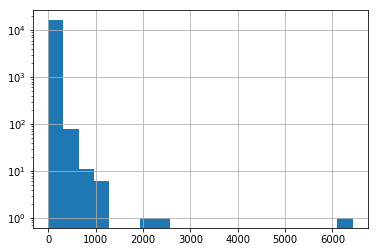

In [34]:
g_filt_05.TPM_NoneZero.hist(bins = 20, log=True)

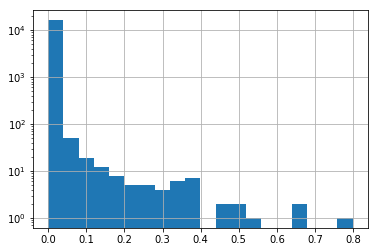

In [35]:
g_filt_05.FractionZero.hist(bins = 20, log=True)

most genes are expressed in a large number of our samples

# QTL Data Processing

In [38]:
def process_qtl_data(fn_top, fn_all, info_cat_per_gene_all, info_all_vars, info_var_gene_wide, gene_types,
                     mappings = False, genes_filt = False, fdr_thresh = 0.1):
    top = pd.read_table(fn_top).pipe(prep_top, genes_filt).pipe(add_fdr)
    all_qtls = pd.read_table(fn_all)
    all_qtls = all_qtls.pipe(annotate_qtl_data, top, 
                         info_cat_per_gene_all, info_all_vars, info_var_gene_wide, gene_types,
                         mappings = mappings, genes_filt= genes_filt)

    all_qtls_filt = all_qtls[all_qtls.in_filtered_genes == True]
#     return all_qtls_filt
    th = all_qtls_filt[(all_qtls_filt.in_filtered_genes) & (all_qtls_filt.top_hit)]
    th_q = th.drop_duplicates(['feature_id'])
    tdf = qvalue(th_q.empirical_feature_p_value)
    th_q = th_q.join(tdf)
    th_q['significant'] = th_q.perm_sig
    p_val_thresh = tdf[tdf.perm_sig == True].perm_pvalue.max()
    all_qtls_filt['significant'] = (all_qtls_filt.empirical_feature_p_value <= p_val_thresh)
    inds = th_q[th_q.perm_sig].gene_var_id.tolist()
    all_qtls_filt['top_hit_final_sig'] = all_qtls_filt.gene_var_id.isin(inds)
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV'}
    all_qtls_filt['SVTYPE_SUPER'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'SV'))
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'MEI', 
          'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV'}
    
    th = th.merge(th_q[['feature_id', 'perm_qvalue', 'perm_sig']], on = 'feature_id', how = 'left')
    all_qtls_filt['SVTYPE_COLLAPSE'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'other SV'))
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI'}
    all_qtls_filt['SVTYPE_NR_C'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    
#     inds = th[th.perm_sig].gene_var_id.unique()
#     all_qtls_filt['lead_w_tie'] = all_qtls_filt.gene_var_id.isin(inds)
    min_p_feat = all_qtls_filt.groupby('feature_id').p_value.min()
    all_qtls_filt = all_qtls_filt.merge(min_p_feat.to_frame('min_p_gene'), 
                                        left_on = 'feature_id', right_index = True, how = 'left')
    all_qtls_filt['lead_gene'] = all_qtls_filt['p_value'] == all_qtls_filt.min_p_gene
    all_qtls_filt['lead_qtl'] = ((all_qtls_filt.lead_gene == True) & (all_qtls_filt.significant))
    return th, all_qtls_filt, all_qtls

In [39]:
def add_tss_dist(all_qtls_filt, tss_info):
    tss_dist = get_tss_dist(tss_info, all_qtls_filt)
    all_qtls_filt = all_qtls_filt.set_index('gene_var_id', drop = False) 
    all_qtls_filt = all_qtls_filt.join(tss_dist.set_index('gene_var_id')[['dist_tss', 'dist_tss_abs']])
    return all_qtls_filt, tss_dist

In [40]:
dy_name = 'qtl_results_01_17_v4'
outdir = os.path.join(private_out, dy_name)

if not os.path.exists(outdir):
    DJ.makedir(outdir)

In [132]:
# newer runs by marc
fn_top_combined = '/frazer01/home/djakubosky/resilio3/Mapping_SV_effects_MAF_bins/GeneLevel_Cis_eQTLs_WGS_SV_05/top_qtl_results_all.txt'
fn_all_combined= '/frazer01/home/djakubosky/resilio3/Mapping_SV_effects_MAF_bins/GeneLevel_Cis_eQTLs_WGS_SV_05/qtl_results_all.txt.gz'

In [92]:
top_hit_all, all_qtls_filt, all_qtls = process_qtl_data(fn_top_combined, fn_all_combined, 
                                                        info_cat_per_gene_all, 
                                                        info_unfilt_pass_rna_398, info_var_gene_wide, 
                                                        gene_types, mappings = False, 
                                                        genes_filt = g_filt_05, fdr_thresh= 0.1)

1839640 1
1839640 2
1839640 3
1839640 4
1839640 5
1839640 6

Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.3997283	

Cumulative number of significant calls:

          <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1    <1
p-value     3408   4111  5282   6031  6859 7969 16018
q-value     3238   3953  5133   5960  6966 8527 16018
local FDR   2642   3152  3900   4328  4772 5413 14842



In [107]:
all_qtls_filt, tss_dist =  add_tss_dist(all_qtls_filt, tss_info)

In [11]:
all_qtls_filt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/all_qtls_combined_filt5.pkl')

In [31]:
inds = all_qtls_filt[(all_qtls_filt.significant == True)].feature_id.unique()

In [40]:
top_sig = all_qtls_filt[(all_qtls_filt.significant == True) & (all_qtls_filt.lead_qtl==True)]

In [34]:
diff = set(inds).difference(inds2)

In [37]:
summary_numbers_all = general_info_qtls(all_qtls_filt)
summary_numbers_th = general_info_th_qtls(all_qtls_filt)

In [18]:
all_qtls_filt[all_qtls_filt.significant].feature_id.unique().shape

(6966,)

In [436]:
summary_numbers_th.reset_index()

,index,Lead_QTLs,unique eGenes,unique eVariants,unique eVariants Non Redundant,no. variants tested,unique variants non-redundant tested,unique genes tested,fraction of tested genes with lead QTL,fraction variants that are lead QTL,fraction NR variants that are lead QTL
0,ALU,294.0,294.0,231.0,231.0,1932.0,1932.0,10873.0,0.027039,0.119565,0.119565
1,BND,89.0,89.0,68.0,68.0,1146.0,1146.0,7045.0,0.012633,0.059337,0.059337
2,DEL,661.0,661.0,517.0,476.0,5443.0,3073.0,14151.0,0.046710,0.094984,0.154897
3,DUP,55.0,55.0,45.0,43.0,623.0,391.0,4481.0,0.012274,0.072231,0.109974
4,INV,11.0,11.0,9.0,9.0,89.0,84.0,1198.0,0.009182,0.101124,0.107143
5,LINE1,31.0,31.0,26.0,26.0,196.0,196.0,1523.0,0.020355,0.132653,0.132653
6,STR,5260.0,5260.0,4087.0,4087.0,33608.0,33608.0,15972.0,0.329326,0.121608,0.121608
7,SVA,28.0,28.0,18.0,18.0,96.0,96.0,1516.0,0.018470,0.187500,0.187500
8,mCNV,294.0,294.0,217.0,180.0,2899.0,947.0,4931.0,0.059623,0.074853,0.190074
9,rMEI,243.0,243.0,180.0,180.0,1453.0,1448.0,9524.0,0.025514,0.123882,0.124309


In [155]:
CM.save_dataframe('top_hits_combined_filt5', top_hit_all, outdir, print_vars_recorded_loc=False)
print
CM.save_dataframe('all_qtls_combined_filt5', all_qtls_filt, outdir, print_vars_recorded_loc=False)
print
CM.save_dataframe('summary_numbers_all5',summary_numbers_all, outdir, print_vars_recorded_loc=False)
print
CM.save_dataframe('summary_numbers_th5',summary_numbers_th, outdir, print_vars_recorded_loc=False)

top_hits_combined_filt5 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/top_hits_combined_filt5.pkl')
top_hits_combined_filt5 = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/top_hits_combined_filt5.tsv', sep='\t')

all_qtls_combined_filt5 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/all_qtls_combined_filt5.pkl')
all_qtls_combined_filt5 = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/all_qtls_combined_filt5.tsv', sep='\t')

summary_numbers_all5 = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/summary_numbers_all5.pkl')
summary_numbers_all5 = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/e

In [133]:
top_hit_all, all_qtls_filt, all_qtls = process_qtl_data(fn_top_combined, fn_all_combined, 
                                                        info_cat_per_gene_all, 
                                                        info_unfilt_pass_rna_398, info_var_gene_wide, 
                                                        gene_types, mappings = False, 
                                                        genes_filt = g_filt_05, fdr_thresh= 0.1)

1839640 1
1839640 2
1839640 3
1839640 4
1839640 5
1839640 6

Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.3997283	

Cumulative number of significant calls:

          <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1    <1
p-value     3408   4111  5282   6031  6859 7969 16018
q-value     3238   3953  5133   5960  6966 8527 16018
local FDR   2642   3152  3900   4328  4772 5413 14842



# Post Processing With More annotations

In [195]:
def annotate_var_egene_loops(var_egene, info_var_annot_nnref1_dl):
    '''add cat saying does the variant hit ANY distal to tested gene
    as opposed to is a loop for that specific egene hit by the variant
    -for a per variant approach this is neccessary, as variants will be double counted
    as both hitting and not hitting the loop'''
    
    
    var_egene['min_dist_pc_anchor'] = var_egene['min_inside_distal	min_outside_distal'.split()].min(axis =1)
    var_egene['min_prox_pc_anchor'] = var_egene['min_inside_proximal min_outside_proximal'.split()].min(axis =1)
 
    var_egene['int_distal_pc_5kb'] = (var_egene[['min_inside_distal', 
                                                 'min_outside_distal']].min(axis = 1)
                                      < 5000)
    var_egene['int_distal_pc_10kb'] = (var_egene[['min_inside_distal', 
                                                  'min_outside_distal']].min(axis = 1)
                                       < 10000)
    try:
        w_cat = var_egene.groupby('Non_Redundant_ID').int_distal_pc_5kb.value_counts().loc[:,True]
    except:
        w_cat = []
    var_egene['int_distal_pc_5kb_any'] = var_egene.Non_Redundant_ID.isin(w_cat.index.tolist())
    
    try:
        w_cat = var_egene.groupby('Non_Redundant_ID').int_distal_pc_10kb.value_counts().loc[:,True]
    except:
        w_cat = []
    var_egene['int_distal_pc_10kb_any'] = var_egene.Non_Redundant_ID.isin(w_cat.index.tolist())
    sd_dict = info_var_annot_nnref1_dl.seg_dupe.to_dict()
    var_egene['seg_dupe']= var_egene.snp_id.apply(lambda x: sd_dict[x])
    
    # condense SVTYPEs 
    
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI'}
    var_egene['SVTYPE_NR_C'] = var_egene.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    
    return var_egene

In [196]:
def prep_var_egene_df(var_egene, pc_distance_summary, var_nnref1_intersect_dragon_slop_1kb,  
                     var_nnref1_closest_dragon):
    
    
    def replace_names(x, cats, replace):
        if x in cats:
            return replace
        else:
            return x
        
        
    def lambda_top_cat(x, cats_ordered):
        for c in cats_ordered:
            if c in x:
                return c
            
    genic_cats_sorted = ['contains_gene', 'contains_exon', 'intersects_exon', 
                     'intersects_promoter', 'intersects_intron', 'intergenic']
    
#     var_egene = var_egene.set_index('gene_var_id', drop = False) 
#     var_egene = var_egene.join(tss_dist.set_index('gene_var_id')[['dist_tss', 'dist_tss_abs']])
    categories_at_gene = var_egene[var_egene.significant==True].groupby('feature_id').genic_category_variant.apply(lambda x: set(x))
    top_category_gene = categories_at_gene.apply(lambda x: lambda_top_cat(x, genic_cats_sorted))
    d = top_category_gene.to_dict()
    var_egene['top_genic_category_gene'] = var_egene.feature_id.apply(lambda x: d.get(x, 'not_egene'))
    egenes = var_egene[var_egene.top_hit_final_sig == True].feature_id.unique().tolist()
    var_egene['is_egene'] = var_egene.feature_id.isin(egenes)
    
    
    
    # consolidate egene_category and super_category
    var_egene['genic_category_consolidated'] = var_egene['genic_category_variant'].apply(lambda x: '{}_eGene'.format(x))
    inds = var_egene[var_egene.genic_category_variant == 'intergenic'].index.tolist()
    var_egene.loc[inds, 'genic_category_consolidated'] = var_egene.loc[inds, 'super_category'].apply(lambda x: '{}_other'.format(x)).tolist()
    inds = var_egene[var_egene.genic_category_consolidated == 'intergenic_other'].index.tolist()
    var_egene.loc[inds, 'genic_category_consolidated'] = var_egene.loc[inds, 'genic_category_consolidated'].apply(lambda x: x.replace('_other', '')).tolist()
    
    
    collapse_categories_dict = {'intersects_promoter_other': 'promoter_other', 
                            'contains_gene_other': 'exonic_other', 'intersects_exon_other': 'exonic_other',
                            'contains_exon_other':'exonic_other', 'intersects_intron_other': 'intronic_other',
                            'intersects_promoter_eGene': 'promoter_eGene', 
                            'contains_gene_eGene': 'exonic_eGene', 'intersects_exon_eGene': 'exonic_eGene',
                            'contains_exon_eGene':'exonic_eGene', 'intersects_intron_eGene': 'intronic_eGene'}
                 
    
    
    var_egene['genic_category_collapsed'] = var_egene.genic_category_consolidated.apply(lambda x:
                                                                                    collapse_categories_dict.get(x,
                                                                                                                 x))
    
    other_cats = ['promoter_other', 'intronic_other', 'exonic_other']
    var_egene['genic_category_eGene'] = var_egene.genic_category_collapsed.apply(lambda x:
                                                                                 replace_names(x,other_cats,
                                                                                            'intersects_other_gene'))


    var_egene['intersects_dragon_enh'] = var_egene.snp_id.isin(var_nnref1_intersect_dragon_slop_1kb.ID.tolist())
    var_egene['ALL_VARS'] = 'ALL_VARS'
    var_egene = var_egene.merge(var_nnref1_closest_dragon[['name', 'distance_dragon_enh']], left_on= 'snp_id', 
                            right_on = 'name', how = 'left')
    
    cols = 'gene_id_mod	snp_id min_inside_distal min_inside_proximal min_outside_distal min_outside_proximal var_inside_and_outside	var_inside_only	var_outside_only	bin_dist_inside_distal	bin_dist_outside_distal	bin_dist_overall_loop	closer_to_inside_proximal category_min bin_dist_up_and_down'.split()
    var_egene = var_egene.merge(pc_distance_summary[cols], left_on = ['feature_id', 'snp_id'], 
                                right_on = ['gene_id_mod', 'snp_id'], how = 'left')   
    
    var_egene.bin_log10_SVLEN_DS_RANGE_capped = var_egene.bin_log10_SVLEN_DS_RANGE_capped.apply(lambda x: 'len_{}'.format(round(x,1)))
    
    inds = var_egene[var_egene.min_inside_proximal == 0].index.tolist()
    var_egene.loc[inds, 'category_min'] = 'inside_proximal'
    var_egene['near_distal_loop'] = var_egene.category_min.isin(['outside_distal', 'inside_distal'])
    var_egene['inside_distal_loop'] = (var_egene.category_min == 'inside_distal')
    
    return var_egene

In [197]:
var_egene = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/all_qtls_combined_filt5.pkl')
pc_distance_summary = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/distance_to_loop_anchors/pc_distance_summary_sv_maf5_v2.pkl')
var_nnref1_intersect_dragon_slop_1kb = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/annotate_regulatory_elements/var_nnref1_intersect_dragon_slop_1kb.pkl')
var_nnref1_closest_dragon = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/annotate_regulatory_elements/var_nnref1_closest_dragon.pkl')

In [198]:
var_egene_annot = var_egene.pipe(prep_var_egene_df, 
                                 pc_distance_summary, var_nnref1_intersect_dragon_slop_1kb,
                                 var_nnref1_closest_dragon)

In [199]:
var_egene_annot = var_egene_annot.pipe(annotate_var_egene_loops, info_unfilt_pass_rna_398)

# Add GWAS and Per Variant Summary

In [200]:
def prep_gene_types_info(df):
    df = df.copy()
    df['gene_id_mod'] = df.gene_id.apply(lambda x: x.split('.')[0])
    df = df.set_index('gene_id_mod', drop = False)
    return df

In [201]:
def extract_per_variant_df(var_egene, gwas, info_all):
    print var_egene.shape[0]
    var_egene['has_gwas'] = var_egene.snp_id.isin(gwas.index.unique())
#     gwas['assoc_set'] = gwas['DISEASE_MOD']
#     cols = 'SV	Pearson_r	Pearson_r2	CHR	rsID_POS	sv_POS	DISEASE_MOD	assoc_set'.split()
    
    var_egene = var_egene.merge(gwas.to_frame('assoc_set'), left_on= 'snp_id', right_index = True, how = 'left')
    
    print var_egene.shape[0]
    
    inds = var_egene[var_egene.assoc_set.isnull() == True].index.tolist()
    var_egene.loc[inds, 'assoc_set'] = [{} for i in range(len(inds))]
    
    
    nr_ids = var_egene.Non_Redundant_ID.unique().tolist()
    sig_assoc = var_egene[var_egene.significant==True].Non_Redundant_ID.unique().tolist()
    th_assoc = var_egene[var_egene.top_hit_final_sig==True].Non_Redundant_ID.unique().tolist()
    
    per_var_info = pd.DataFrame(index = nr_ids)
    per_var_info['significant_association'] = per_var_info.index.isin(sig_assoc)
    per_var_info['lead_association'] = per_var_info.index.isin(th_assoc)
    
    
    num_egenes_total = (var_egene[var_egene.significant==True]
                    .groupby('Non_Redundant_ID').feature_id.apply(lambda x: len(set(x))))
    num_egenes_th = (var_egene[var_egene.top_hit_final_sig]
                 .groupby('Non_Redundant_ID').feature_id.apply(lambda x: len(set(x))))
    num_genes_tested = var_egene.groupby('Non_Redundant_ID').feature_id.apply(lambda x: len(set(x)))
    thresh = 10000
    num_genes_tested_loop = (var_egene[(var_egene.min_dist_pc_anchor < thresh) & 
                                      (var_egene.closer_to_inside_proximal == 
                                       False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len))
    num_egenes_loop = var_egene[(var_egene.min_dist_pc_anchor < thresh) 
                                & (var_egene.significant==True) & 
                                (var_egene.closer_to_inside_proximal ==
                                 False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len)

    num_egenes_loop_th =  var_egene[(var_egene.min_dist_pc_anchor < thresh) & (var_egene.top_hit_final_sig==True) & (var_egene.closer_to_inside_proximal == False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len)
    
    per_var_info = per_var_info.join(num_genes_tested_loop.to_frame('num_genes_tested_loop'), 
                                 lsuffix='_loop', rsuffix= '')
    per_var_info = per_var_info.join(num_egenes_loop.to_frame('num_egenes_loop'), lsuffix='_loop', rsuffix= '')
    per_var_info = per_var_info.join(num_egenes_loop_th.to_frame('num_egenes_loop_th'), lsuffix='_loop', rsuffix= '')
    per_var_info = per_var_info.join(num_egenes_total.to_frame('num_egenes'), lsuffix='_loop', rsuffix= '')
    per_var_info = per_var_info.join(num_egenes_th.to_frame('num_egenes_lead'), lsuffix='_loop', rsuffix= '')
    per_var_info = per_var_info.join(num_genes_tested.to_frame('num_genes_tested'), lsuffix='_loop', rsuffix= '')
    assoc = var_egene.groupby('Non_Redundant_ID').assoc_set.apply(lambda x: list(x))
    assoc = assoc.apply(lambda x: set(CM.flatten_list(map(list, x))))
    per_var_info = per_var_info.join(assoc.to_frame('association'))
    
    
    inds = var_egene[var_egene.has_gwas].Non_Redundant_ID.unique()
    per_var_info['has_gwas'] = per_var_info.index.isin(inds)

    cols = 'num_egenes	num_egenes_lead'.split()
    per_var_info[cols] = per_var_info[cols].fillna(0)

    cols = 'num_egenes_loop	num_egenes_loop_th'.split()
    per_var_info[cols] = per_var_info[cols].fillna(0)

    t = info_all[['SVTYPE_NR', 'Non_Redundant_ID']].drop_duplicates().set_index('Non_Redundant_ID')
    per_var_info = per_var_info.join(t)
    per_var_info['ALL_VARS'] = 'ALL_VARS'
    per_var_info['Non_Redundant_ID'] = per_var_info.index
    return var_egene, per_var_info

In [202]:
def lambda_int_str(x):
    try:
        out = int(x)
    except:
        out = copy.deepcopy(x)
    return str(out)

In [203]:
def prep_gwas_all(gwas_all, gwas_locs):
    gwas_all['P-VALUE'] = gwas_all['P-VALUE'].astype(float)
    gwas_all = gwas_all[gwas_all['P-VALUE'] < 5e-8]
    gwas_all = gwas_all[gwas_all.SNP_ID_CURRENT.isnull() == False]
    gwas_all['rsID'] = gwas_all.SNP_ID_CURRENT.apply(lambda x: 'rs{}'.format(lambda_int_str(x)))
    gwas_all = gwas_all[gwas_all.rsID.isin(gwas_locs.rsID.tolist())]
    return gwas_all

In [204]:
def prep_info_pass_for_merge_pv(info):
    info = info.copy()
    info['chrom'] = info.CHROM.apply(lambda x: "chr{}".format(str(x)))
    c1 =['NR_ID', 'ID', 'CALLER', 'NMODE_all_rna', 'NMODE_AF_all_rna', 'SVTYPE_all_rna','ALLELES_DIST_DICT_all_rna', 'SUBTYPE_all_rna', 'MIN_ALLELE_all_rna', 'MAX_ALLELE_all_rna', 'ALLELES_all_rna']

    c2 = [u'SVLEN', u'MAX_ALLELE_CHANGE',
       u'ALLELE_DIFF', u'SVLEN_DS_RANGE', u'MHC', u'VDJ', u'centromere',
       u'seg_dupe', u'pseudo_auto', u'is_SVLEN', u'log10_SVLEN',
       u'log10_SVLEN_DS_RANGE', u'bin_log10_SVLEN', u'bin_log10_SVLEN_capped',
       u'bin_log10_SVLEN_DS_RANGE', u'bin_log10_SVLEN_DS_RANGE_capped',
       u'super_category', u'genes_affected', u'num_genes_affected',
       u'start_variant', u'end_variant', u'ucsc_coords', u'chrom']

    tdf = info[c1 + c2]
    tdf.columns = map(lambda x: x.replace('_all_rna', ''), tdf.columns.tolist())
    return tdf

In [205]:
fn = '/projects/hipsci/analysis/GWAS_r2/data/gwas_SNPs_locs.txt'
gwas_locs = pd.read_table(fn, names = ['CHROM', 'POS', 'rsID'])

In [206]:
fn = '/publicdata/gwas_catalog_20181221/gwas_catalog_v1.0.2-associations_e93_r2018-12-21.tsv'
gwas_all = pd.read_table(fn).pipe(prep_gwas_all, gwas_locs)
gwas_all['DISEASE_TRAIT_MOD'] = gwas_all['DISEASE/TRAIT'].apply(lambda x: x.replace(',', ' '))

c = ['DISEASE/TRAIT','DISEASE_TRAIT_MOD']
tdf = gwas_all[c].drop_duplicates()
d = tdf.set_index('DISEASE/TRAIT').to_dict()
fns = glob.glob('/projects/hipsci/analysis/GWAS_r2/data/SNP_SV_r2_V02/GWAS_SV_r2_chr*_80.txt')
gwas = pd.concat([pd.read_table(i) for i in fns])
t = gwas_all.groupby('rsID').DISEASE_TRAIT_MOD.apply(lambda x: set(list(x)))
gwas['DISEASE_MOD'] = gwas.rsID.apply(lambda x: t[x])

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (23,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [209]:
assoc_per_var = gwas.groupby('SV')['DISEASE.TRAIT'].apply(lambda x: set(list(x)))
info_unfilt_pass_rna_398['Non_Redundant_ID'] = info_unfilt_pass_rna_398.NR_ID

In [210]:
var_egene_annot, per_var_info = extract_per_variant_df(var_egene_annot, assoc_per_var, info_unfilt_pass_rna_398)

630982
630982


In [213]:
tdf = info_unfilt_pass_rna_398.pipe(prep_info_pass_for_merge_pv)

In [214]:
per_var_info = per_var_info.merge(tdf, left_index=True, right_on= 'ID', how = 'left')

In [215]:
CM.save_dataframe('per_variant_info_sv_only', per_var_info, outdir, 
                  print_vars_recorded_loc=False)

per_variant_info_sv_only = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/per_variant_info_sv_only.pkl')
per_variant_info_sv_only = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/per_variant_info_sv_only.tsv', sep='\t')


In [216]:
CM.save_dataframe('var_egene_annot_maf5_sv_only', var_egene_annot, outdir, 
                  print_vars_recorded_loc=False)

var_egene_annot_maf5_sv_only = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/var_egene_annot_maf5_sv_only.pkl')
var_egene_annot_maf5_sv_only = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/var_egene_annot_maf5_sv_only.tsv', sep='\t')


# Joint processing

In [110]:
def prep_info_pass_for_merge_joint(info):
    info = info.copy()
    c1 =['NR_ID', 'ID', 'CALLER', 'NMODE_all_rna', 'NMODE_AF_all_rna', 'SVTYPE_all_rna', 'SVTYPE_NR', 'ALLELES_DIST_DICT_all_rna', 'SUBTYPE_all_rna', 'MIN_ALLELE_all_rna', 'MAX_ALLELE_all_rna']

    c2 = [u'SVLEN', u'MAX_ALLELE_CHANGE',
       u'ALLELE_DIFF', u'SVLEN_DS_RANGE', u'MHC', u'VDJ', u'centromere',
       u'seg_dupe', u'pseudo_auto', u'is_SVLEN', u'log10_SVLEN',
       u'log10_SVLEN_DS_RANGE', u'bin_log10_SVLEN', u'bin_log10_SVLEN_capped',
       u'bin_log10_SVLEN_DS_RANGE', u'bin_log10_SVLEN_DS_RANGE_capped',
       u'start_variant', u'end_variant', u'ucsc_coords', u'chrom']

    tdf = info[c1 + c2]
    tdf.columns = map(lambda x: x.replace('_all_rna', ''), tdf.columns.tolist())
    return tdf

In [111]:
def annotate_qtl_data_snp_sv(all_qtls, top, info_cat_per_gene_all, info_all_var, info_var_gene_wide,
                      gene_types, mappings = False, genes_filt = False):
    all_qtls['gene_var_id'] = all_qtls['feature_id'] + '_' + all_qtls['snp_id']
    
    all_qtls = all_qtls.drop_duplicates('gene_var_id')
    # merge the info onto the top hits df
    all_qtls = pd.merge(all_qtls, info_cat_per_gene_all[['gene_id_mod', 'ID', 'genic_category_variant']], how='left', left_on=['feature_id', 'snp_id'], right_on=['gene_id_mod', 'ID'])
    

    cols = ['ID'] + ' SVTYPE CALLER	NONREF_AF_ipscore	ALLELES_DIST_ipscore NONREF_AF_hipsci	ALLELES_DIST_hipsci	NNREF_hipsci NONREF_AF_all_rna	ALLELES_DIST_all_rna	NNREF_all_rna start_variant end_variant ucsc_coords Non_Redundant_ID SVTYPE_NR'.split()
    
    info_all_trunc = info_all_var.pipe(prep_info_pass_for_merge_joint)
    all_qtls = all_qtls.merge(info_all_trunc, left_on='snp_id', right_on= 'ID', how = 'left')

#     all_qtls['genic_category_variant'] = all_qtls['genic_category_variant'].fillna('intergenic')
    all_qtls['Non_Redundant_ID'] = all_qtls['NR_ID']
    
#     all_qtls = all_qtls.merge(info_all_var[cols], left_on='snp_id', right_on= 'ID', how = 'left')
    all_qtls.SVTYPE = all_qtls.SVTYPE.fillna('SNP/INDEL')
    all_qtls['SVTYPE_NR'] = all_qtls.SVTYPE_NR.fillna('SNP/INDEL')
   
    
    inds = all_qtls[all_qtls.SVTYPE == 'SNP/INDEL'].index.tolist()
    

    all_qtls.loc[inds, 'start_variant'] = all_qtls.loc[inds, 'snp_id'].apply(lambda x: int(x.split('_')[1]))
    all_qtls.loc[inds, 'end_variant'] = all_qtls.loc[inds, 'snp_id'].apply(lambda x: int(x.split('_')[1]))
    all_qtls['genic_category_variant'] = all_qtls['genic_category_variant'].fillna('intergenic')
    
    p_val_sig_all = get_pval_threshold_for_fdr(top)

    all_qtls['coding'] = False
    inds = all_qtls[all_qtls.genic_category_variant.isin(['contains_gene', 'contains_exon', 'intersects_exon'])].index.tolist()
    all_qtls.loc[inds, 'coding'] = True    
    all_qtls['significant'] = (all_qtls['empirical_feature_p_value'] < p_val_sig_all)
    
    all_qtls = correct_betas(all_qtls, info_all_trunc)
    all_qtls['top_hit'] = all_qtls.gene_var_id.isin(top.gene_var_id.tolist())
    all_qtls['top_hit_final'] = all_qtls.gene_var_id.isin(top[top.fdr_global < 0.1].gene_var_id.tolist())
    
    
    if mappings:
        all_qtls['Non_Redundant_ID'] = all_qtls['snp_id'].apply(lambda x: mappings.get(x, x))
        
    if type(genes_filt) != bool:
        all_qtls['in_filtered_genes'] = all_qtls.feature_id.isin(genes_filt.index.tolist())
    
    all_qtls['gene_distance'] = all_qtls.pipe(dist_lambda, 'start_variant', 'end_variant', 
                                              'feature_start', 'feature_end')
    all_qtls = all_qtls.drop(['ID_x', 'ID_y'], axis = 1)
    info_var_gene_wide.index = info_var_gene_wide.ID 
    all_qtls = all_qtls.merge(info_var_gene_wide[['super_category', 'genes_supercategory', 'num_genes_affected']], left_on= 'snp_id', right_index=True, how = 'left')
    
    all_qtls = all_qtls.merge(gene_types[['gene_type', 'gene_name']], left_on= 'feature_id', right_index=True, how = 'left')
    all_qtls['top_hit_final'] = all_qtls.gene_var_id.isin(top.gene_var_id.tolist())
    return all_qtls, p_val_sig_all

In [112]:
def prep_top_deduplicate(top):
    top = top.copy()
    top['gene_var_id'] = top['feature_id'] + '_' + top['snp_id']
    top = top.drop_duplicates('feature_id')
    return top

In [113]:
def classify_snv_indel(x):
    spl = x.split('_')
    ref = spl[-2]
    alt = spl[-1]
    
    len_ref = len(ref)
    len_alt = len(alt)
    
    if alt == "*":
        return 'INDEL'
    
    elif len_ref == len_alt:
        return 'SNV'
    
    else:
        return 'INDEL'

In [114]:
def classify_indel_change(x):
    spl = x.split('_')
    ref = spl[-2]
    alt = spl[-1]
    
    len_ref = len(ref)
    len_alt = len(alt)
    
    change = (len_alt - len_ref)
    
    if alt == "*":
        return -1 * len_ref
    
    else:
        return change

def classify_snv_indel_subcat(x):
    if x == 0:
        return 'SNV'
    if x > 0:
        return 'INS'
    if x < 0:
        return 'DEL'
    
    return 'missed_case'

In [115]:
def correct_svtypes_cols(top_hits_filt_gene):
    
    top_hits_snp_indel = top_hits_filt_gene[top_hits_filt_gene.SVTYPE == 'SNP/INDEL']
    top_hits_snp_indel['variant_type'] = top_hits_snp_indel.snp_id.apply(lambda x: classify_snv_indel(x))

    inds = top_hits_snp_indel.index.tolist()
    top_hits_filt_gene.loc[inds, 'SVTYPE'] = top_hits_snp_indel['variant_type']
    top_hits_filt_gene.loc[inds, 'SVTYPE_NR'] = top_hits_filt_gene.SVTYPE
    
    inds =  top_hits_filt_gene[ top_hits_filt_gene.Non_Redundant_ID.isnull()==True].index.tolist()
    top_hits_filt_gene.loc[inds, 'Non_Redundant_ID'] = top_hits_filt_gene.loc[inds, 'snp_id'] 
    return top_hits_filt_gene

In [121]:
def process_qtl_data_snp_sv(fn_top, fn_all, info_cat_per_gene_all, info_all_vars, info_var_gene_wide, gene_types,
                     mappings = False, genes_filt = False, fdr_thresh = 0.1):
    top = pd.read_table(fn_top).pipe(prep_top, genes_filt).pipe(prep_top_deduplicate).pipe(add_fdr)
    all_qtls = pd.read_table(fn_all).pipe(prep_top_deduplicate)
    all_qtls, p_val_sig = all_qtls.pipe(annotate_qtl_data_snp_sv, top, 
                         info_cat_per_gene_all, info_all_vars, info_var_gene_wide, gene_types,
                         mappings = mappings, genes_filt= genes_filt)
#     inds = top[top.fdr_global < fdr_thresh].gene_var_id.tolist()
#     th = all_qtls[(all_qtls.top_hit == True) & (all_qtls.gene_var_id.isin(inds)) & 
#                   (all_qtls.in_filtered_genes == True)]
    all_qtls_filt = all_qtls[all_qtls.in_filtered_genes == True]
#     th_q = all_qtls[all_qtls.in_filtered_genes == True]
    th_q = all_qtls_filt.drop_duplicates(['gene_var_id'])
    th_q = th_q.drop_duplicates(['feature_id'])
    tdf = qvalue(th_q.empirical_feature_p_value)
    th_q = th_q.join(tdf)
    th_q['perm_pvalue'] = th_q.perm_pvalue.astype(float)
    all_qtls_filt = all_qtls_filt.merge(th_q[['feature_id', 'perm_qvalue', 'perm_sig']], on = 'feature_id', 
                                        how = 'left')
    all_qtls_filt['significant'] = all_qtls_filt.perm_sig
    p_val_thresh = tdf[tdf.perm_sig == True].perm_pvalue.max()
    
    all_qtls_filt['significant'] = (all_qtls_filt.empirical_feature_p_value <= p_val_thresh)
    inds = all_qtls_filt[all_qtls_filt.perm_sig].gene_var_id.tolist()
    all_qtls_filt['top_hit_final_sig'] = all_qtls_filt.gene_var_id.isin(inds)
    all_qtls_filt = all_qtls_filt.pipe(correct_svtypes_cols)
    all_qtls_filt = all_qtls_filt.pipe(add_fdr)
    
    
    return all_qtls_filt, all_qtls, p_val_thresh, p_val_sig, th_q

In [117]:
def general_info_th_qtls_snv_indel(all_output, sv_output, info_all_vars):
    inds= sv_output.snp_id.unique().tolist()
    input_variants = info_all_vars.loc[inds].SVTYPE_NR.value_counts().to_frame('no. variants tested')
    input_variants.loc['SNV'] = 20000000
    input_variants.loc['INDEL'] = 3000000
    
    
    non_redundant_vars_per_class = sv_output.groupby('VARIANT_TYPE_NR').Non_Redundant_ID.apply(lambda x: len(set(x))).to_frame('unique variants non-redundant tested')
    non_redundant_vars_per_class.loc['SNV'] = 20000000
    non_redundant_vars_per_class.loc['INDEL'] = 3000000
    
    
    genes_tested_per_class = all_output.groupby('VARIANT_TYPE_NR').feature_id.apply(lambda x: len(set(x))).to_frame('unique genes tested')
    top_sig = all_output[(all_output.significant == True) & (all_output.top_hit_final == True)]
    t1 = top_sig.VARIANT_TYPE_NR.value_counts().to_frame('Lead_QTLs')

    t2 = top_sig.groupby('VARIANT_TYPE_NR').feature_id.apply(lambda x: len(set(x))).to_frame('unique eGenes')

    t3 = top_sig.groupby('VARIANT_TYPE_NR').snp_id.apply(lambda x: len(set(x))).to_frame('unique eVariants')

    t4 = top_sig.groupby('VARIANT_TYPE_NR').Non_Redundant_ID.apply(lambda x: len(set(x))).to_frame('unique eVariants Non Redundant')
    
    general_numbers_fdr10 = pd.concat([t1, t2, t3, t4, input_variants, non_redundant_vars_per_class,
                                   genes_tested_per_class], axis = 1)

    general_numbers_fdr10['fraction of tested genes with lead QTL'] = general_numbers_fdr10['unique eGenes'] / general_numbers_fdr10['unique genes tested']

    general_numbers_fdr10['fraction variants that are lead QTL'] = general_numbers_fdr10['unique eVariants']/ general_numbers_fdr10['no. variants tested'] 

    general_numbers_fdr10['fraction NR variants that are lead QTL'] = general_numbers_fdr10['unique eVariants Non Redundant']/ general_numbers_fdr10['unique variants non-redundant tested'] 
    
    general_numbers_fdr10.loc['total'] = general_numbers_fdr10.sum(axis = 0)
    
    return general_numbers_fdr10

In [118]:
def annotate_snv_indel(snv_indel_top_all):
    snv_indel = snv_indel_top_all[snv_indel_top_all.CALLER.isnull() == True]

    snv_indel['CHANGE'] = snv_indel.snp_id.apply(lambda x: classify_indel_change(x))
    snv_indel['VARIANT_SUBTYPE'] = snv_indel.CHANGE.apply(lambda x: classify_snv_indel_subcat(x))
    snv_indel['CALLER'] = 'GATK'

    snv_indel['start_variant'] =  snv_indel.snp_id.apply(lambda x: x.split('_')[1]).astype(int)
    snv_indel['end_variant'] =  snv_indel.start_variant
    snv_indel['VARIANT_TYPE'] = snv_indel.snp_id.apply(lambda x: classify_snv_indel(x))
    snv_indel['VARIANT_SUBCLASS'] = snv_indel.VARIANT_TYPE + snv_indel.VARIANT_SUBTYPE.apply(lambda x: "_{}".format(x).replace('_SNV', ''))
    snv_indel['adjust'] = 0
    inds = snv_indel[snv_indel.VARIANT_SUBTYPE == 'DEL'].index.tolist()
    snv_indel.loc[inds, 'adjust'] = snv_indel.loc[inds, 'CHANGE'].abs()
    snv_indel['end_variant'] = snv_indel.end_variant + snv_indel.adjust

    snv_indel['ref'] = snv_indel.snp_id.apply(lambda x: x.split('_')[-2])
    snv_indel['alt'] = snv_indel.snp_id.apply(lambda x: x.split('_')[-1])

    snv_indel['chrom'] = 'chr' + snv_indel.feature_chromosome.astype(str)
    
    return snv_indel

In [119]:
def annot_super_cats(var_egene):
    var_egene['genic_category_consolidated'] = var_egene['genic_category_variant'].apply(lambda x: '{}_eGene'.format(x))
    inds = var_egene[var_egene.genic_category_variant == 'intergenic'].index.tolist()
    var_egene.loc[inds, 'genic_category_consolidated'] = var_egene.loc[inds, 'super_category'].apply(lambda x: '{}_other'.format(x)).tolist()
    inds = var_egene[var_egene.genic_category_consolidated == 'intergenic_other'].index.tolist()
    var_egene.loc[inds, 'genic_category_consolidated'] = var_egene.loc[inds, 'genic_category_consolidated'].apply(lambda x: x.replace('_other', '')).tolist()
    
    
    collapse_categories_dict = {'intersects_promoter_other': 'promoter_other', 
                            'contains_gene_other': 'exonic_other', 'intersects_exon_other': 'exonic_other',
                            'contains_exon_other':'exonic_other', 'intersects_intron_other': 'intronic_other',
                            'intersects_promoter_eGene': 'promoter_eGene', 
                            'contains_gene_eGene': 'exonic_eGene', 'intersects_exon_eGene': 'exonic_eGene',
                            'contains_exon_eGene':'exonic_eGene', 'intersects_intron_eGene': 'intronic_eGene'}



    var_egene['genic_category_collapsed'] = var_egene.genic_category_consolidated.apply(lambda x:
                                                                            collapse_categories_dict.get(x,x))
    return var_egene

In [70]:

fn_top_combined = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_data_sv_snp_1_14_19/top_qtl_results_sv_snp_combined.txt'

top_filt, top_hits_unfilt, p_val_thresh_story, p_val_thresh_fdr, th_q =  process_qtl_data_snp_sv(fn_top_combined,
                                                                                           fn_top_combined, 
                                                        info_cat_per_gene_all, 
                                                        info_unfilt_pass_rna_398, info_var_gene_wide, 
                                                        gene_types, mappings = False, 
                                                        genes_filt = g_filt_05, fdr_thresh= 0.1)

convert = {'STR':'STR', 'INDEL_DEL': 'INDEL', 'INDEL_INS':'INDEL', 'SNV': 'SNV'}
top_filt['SVTYPE_SUPER'] = top_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'SV'))
print p_val_thresh_story, 'story'
print p_val_thresh_fdr, 'fdr'


Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.2407432	

Cumulative number of significant calls:

          <1e-04 <0.001 <0.01 <0.025 <0.05  <0.1    <1
p-value     6230   7158  8377   9048  9713 10602 16018
q-value     6414   7462  9002   9997 11197 12888 16018
local FDR   5481   6185  7238   7790  8266  8928 15339

0.145038517071 story
0.062166965330594126 fdr


In [277]:
top_filt['VARIANT_TYPE'] = top_filt['SVTYPE']
top_filt['VARIANT_TYPE_NR'] = top_filt['SVTYPE_NR']

snv_indel = annotate_snv_indel(top_filt)

inds = snv_indel.index
top_filt.loc[inds, 'SVLEN'] = snv_indel.CHANGE
top_filt.loc[inds, 'SVTYPE'] = snv_indel.VARIANT_SUBCLASS
top_filt.loc[inds, 'SVTYPE_NR'] = snv_indel.VARIANT_SUBCLASS

top_filt.loc[inds, 'VARIANT_TYPE'] = snv_indel.VARIANT_TYPE
top_filt.loc[inds, 'VARIANT_TYPE_NR'] = snv_indel.VARIANT_TYPE


top_filt.loc[inds, 'start_variant'] = snv_indel.start_variant
top_filt.loc[inds, 'end_variant'] = snv_indel.end_variant

In [278]:
top_filt['genic_category_variant'] = top_filt.genic_category_variant.fillna('intergenic')

top_filt['super_category'] = top_filt.super_category.fillna('intergenic')
top_filt = annot_super_cats(top_filt)

In [182]:
CM.save_dataframe('top_hits_sv_snp_maf5_story', top_filt, outdir)

top_hits_sv_snp_maf5_story = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/top_hits_sv_snp_maf5_story.pkl')
top_hits_sv_snp_maf5_story = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/top_hits_sv_snp_maf5_story.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/load_pickled_nb_variables.py


In [279]:
general_info_th_qtls_snv_indel(top_filt, top_filt, info_unfilt_pass_rna_398).reset_index()

,index,Lead_QTLs,unique eGenes,unique eVariants,unique eVariants Non Redundant,no. variants tested,unique variants non-redundant tested,unique genes tested,fraction of tested genes with lead QTL,fraction variants that are lead QTL,fraction NR variants that are lead QTL
0,ALU,9.0,9.0,8.0,8.0,10.0,10.0,12.0,0.750000,0.800000,0.800000
1,BND,8.0,8.0,6.0,6.0,9.0,9.0,11.0,0.727273,0.666667,0.666667
2,DEL,51.0,51.0,42.0,40.0,53.0,48.0,61.0,0.836066,0.792453,0.833333
3,DUP,9.0,9.0,8.0,8.0,12.0,11.0,14.0,0.642857,0.666667,0.727273
4,INDEL,2685.0,2685.0,2642.0,2642.0,3000000.0,3000000.0,4892.0,0.548855,0.000881,0.000881
5,LINE1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000
6,SNV,8148.0,8148.0,7954.0,7954.0,20000000.0,20000000.0,10655.0,0.764711,0.000398,0.000398
7,STR,170.0,170.0,140.0,140.0,207.0,207.0,242.0,0.702479,0.676329,0.676329
8,SVA,2.0,2.0,2.0,2.0,3.0,3.0,5.0,0.400000,0.666667,0.666667
9,mCNV,111.0,111.0,85.0,77.0,93.0,84.0,120.0,0.925000,0.913978,0.916667
